# XGBoost(eXtra Gradient Boost)

부스팅(Boosting) 

- 여러 개의 약한 학습기(weak learner)를 순차적으로 학습-예측하면서
- 잘못 예측된 데이터에 가중치(weight) 부여를 통해
- 오류를 개선해 나가면서 학습하는 방식

대표적인 부스팅 알고리즘 
- GBM
- AdaBoost
- xgboost
- ligt_gbm

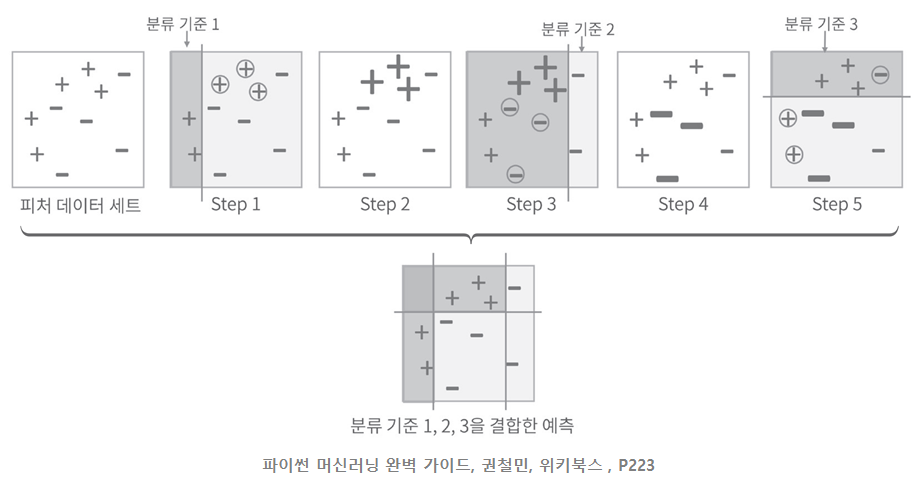

## XGBoost 개요
- 트리 기반의 앙상블 학습에서 가장 각광받고 있는 알고리즘 중 하나
- 압도적인 수치의 차이는 아니지만, 분류에 있어서 일반적으로 다른 머신러닝보다 뛰어난 예측 성능을 나타냄
- GBM에 기반하지만, GBM의 단점인 느린 수행 시간 및 과적합 규제 부재 등의 문제 해결
- 특히 병렬 CPU 환경에서 병렬 학습이 가능해 기존 GBM보다 빠르게 학습 완료

#### XGBoost 장점
- 뛰어난 예측 성능
- 빠른 수행 시간
- 과적합 규제 
- 가지치기 (pruning) - 더 이상 긍정 이득이 없는 분할을 가지치기 해서 분할 수를 줄이게 됨
    - max_depth 파라미터로 가지치기 조정
- 교차 검증 내장
- 결손값 자체 처리


## XGBoost 라이브러리 -XGBoost 파이썬 구현

(1) XGBoost는 처음에는 C/C++로 작성되었음

(2) 파이썬에서도 XGBoost를 구동할 수 있도록 파이썬 패키지(xgboost) 제공
* 패키지 역할 : 대부분 C/C++ 핵심 라이브러리를 호출하는 것
* 사이킷런과 호환되지 않는 독자적인 XGBoost 전용 패키지
* 따라서 사이킷런의 fit(), predict() 메서드 같은 사이킷런 고유 아키텍처 적용 불가
* 다양한 유틸리티(cross_val_score, GridSearchCV, Pipeline 등)도 사용 불가
* '파이썬 래퍼 XGBoost 모듈'로 지칭

(3) 파이썬 기반의 ML 이용자들이 사이킷런을 많이 사용하기 때문에  
사이킷런과 연동할 수 있는 래퍼 클래스(Wrapper class) 제공
* XGBClassifer와 XGBRegressor 래퍼 클래스
*  사이킷런 estimator가 학습을 위해 사용하는 fit()과 predict() 등 
*  표준 사이킷런 개발 프로세스 및 다양한 유틸리티 활용 가능
* '사이킷런 래퍼 XGBoost 모듈'로 지칭

**'파이썬 래퍼 XGBoost 모듈'과 '사이킷런 래퍼 XGBoost 모듈' 차이점**
- '사이킷런 래퍼 XGBoost 모듈' : 사이킷런의 Estimator와 사용법 동일
- '파이썬 래퍼 XGBoost 모듈' : 파이썬 네이티브 XGBoost 고유의 API와 하이퍼 파라미터 이용
- 크게 다르지는 않지만 몇 가지 주의할 점이 있음
- 파이썬 Wrapper : 사이킷런 Wrapper
    - eta : learning_rate  (학습률)
    - num_boost_rounds : n_estimators  (학습기의 개수 : 반복 수행 횟수)    

In [ ]:
!pip install xgboost

# 위스콘신 유방암 예측 예제  
(1) 사이킷런 Wrapper XGBoost 적용

- 악성 종양(malignant)인지 양성 종양(benign)인지를 분류한 세트
- 양성 : 제거하여 치유할 수 있는 종양. 성장속도 느리고 전이되지 않음
- 악성 : 암. 빠르게 성장하고 전이되어 생명 위협

In [3]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [4]:
# 데이터 세트 로딩
dataset = load_breast_cancer()
X_features= dataset.data
y_label = dataset.target

In [5]:
# 데이터 확인하기 위해 데이터 프레임으로 생성
cancer_df = pd.DataFrame(data=X_features, columns=dataset.feature_names)
cancer_df['target']= y_label # 맨 마지막에 target 열 추가
cancer_df.head(3)

# target : 0 악성, 1 양성

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0


In [6]:
# 레이블 값 분포 확인


In [7]:
# 학습 데이터/테스트 데이터 분리 8:2
X_train, X_test, y_train, y_test=train_test_split(X_features, y_label,
                                         test_size=0.2, random_state=156 )
print(X_train.shape , X_test.shape)

(455, 30) (114, 30)


In [20]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

# 수정된 get_clf_eval() 함수 
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}'.format(accuracy, precision, recall, f1))

## (1) 사이킷런 Wrapper XGBoost 개요 및 적용

- 사이킷런의 기본 Estimator를 그대로 상속해서 만들었기 때문에  
- fit()과 predict()만으로 학습과 예측 가능  

- 하이퍼 파라미터
    - 사이킷런 Wrapper  
        - learning_rate (학습률)  
        - n_estimators (학습기의 개수 : 반복 수행 횟수)  

- 분류를 위한 XGBClassifier 클래스
- 회귀를 위한 XGBRegressor 클래스


- 파이썬 래퍼 XGBoost에서 사용하는 하이퍼파라미터와 호환성을 유지하기 위해 몇개 하이퍼파라미터를 변경
    - eta  → learning_rate
    - sub_sample → subsample
    - lambda → reg_lambda
    - alpha → reg_alpha
    
    
- xgboost의 n_estimators와 num_boost_round는 동일한 파라미터
    - 이를 동시에 사용할 경우 
        - 파이썬 래퍼 XGBoost API는 n_estimator를 무시하고 num_boost_round를 적용
        - 사이킷런 래퍼 XGBoost는 n_estimator 파라미터를 적용

In [23]:
# 사이킷런 래퍼 XGBoost 클래스인 XGBClassifier 임포트
from xgboost import XGBClassifier

In [24]:

# 주의사항 : 검증 데이터 세트를 따로 생성해서 검증을 진행 해야 함
# - 예제 데이터의 양이 검증요 데이터를 추출하기에 너무 적어 test용 데이터를 검증용과 테스트용으로 사용
# - 실제 분석에서는 이렇게 진행하면 안됨

In [26]:
# 모델 객체 인스턴스 생성



In [28]:
# 학습과 예측 수행 : fit(), predict(), predict_proba() 이용
# fit()에서 early_stopping_rounds설정, eval_metric도 설정


[0]	validation_0-logloss:0.61352
[1]	validation_0-logloss:0.54784
[2]	validation_0-logloss:0.49425
[3]	validation_0-logloss:0.44799
[4]	validation_0-logloss:0.40911
[5]	validation_0-logloss:0.37498
[6]	validation_0-logloss:0.34571
[7]	validation_0-logloss:0.32053
[8]	validation_0-logloss:0.29721
[9]	validation_0-logloss:0.27799
[10]	validation_0-logloss:0.26030
[11]	validation_0-logloss:0.24604
[12]	validation_0-logloss:0.23156
[13]	validation_0-logloss:0.22005
[14]	validation_0-logloss:0.20857
[15]	validation_0-logloss:0.19999
[16]	validation_0-logloss:0.19012
[17]	validation_0-logloss:0.18182
[18]	validation_0-logloss:0.17473
[19]	validation_0-logloss:0.16766
[20]	validation_0-logloss:0.15820
[21]	validation_0-logloss:0.15473
[22]	validation_0-logloss:0.14895
[23]	validation_0-logloss:0.14331
[24]	validation_0-logloss:0.13634
[25]	validation_0-logloss:0.13278
[26]	validation_0-logloss:0.12791
[27]	validation_0-logloss:0.12526
[28]	validation_0-logloss:0.11998
[29]	validation_0-loglos

[238]	validation_0-logloss:0.08639
[239]	validation_0-logloss:0.08634
[240]	validation_0-logloss:0.08618
[241]	validation_0-logloss:0.08619
[242]	validation_0-logloss:0.08625
[243]	validation_0-logloss:0.08626
[244]	validation_0-logloss:0.08629
[245]	validation_0-logloss:0.08622
[246]	validation_0-logloss:0.08640
[247]	validation_0-logloss:0.08635
[248]	validation_0-logloss:0.08628
[249]	validation_0-logloss:0.08645
[250]	validation_0-logloss:0.08629
[251]	validation_0-logloss:0.08631
[252]	validation_0-logloss:0.08636
[253]	validation_0-logloss:0.08639
[254]	validation_0-logloss:0.08649
[255]	validation_0-logloss:0.08644
[256]	validation_0-logloss:0.08629
[257]	validation_0-logloss:0.08646
[258]	validation_0-logloss:0.08639
[259]	validation_0-logloss:0.08644
[260]	validation_0-logloss:0.08646
[261]	validation_0-logloss:0.08649
[262]	validation_0-logloss:0.08644
[263]	validation_0-logloss:0.08647
[264]	validation_0-logloss:0.08632
[265]	validation_0-logloss:0.08649
[266]	validation_0-l

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=400, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [30]:
# 예측 성능 평가 수행


오차 행렬
[[34  3]
 [ 1 76]]
정확도: 0.9649, 정밀도: 0.9620, 재현율: 0.9870,    F1: 0.9744, AUC:0.9954


In [34]:
# early stopping 설정
from xgboost import XGBClassifier



[0]	validation_0-logloss:0.61352
[1]	validation_0-logloss:0.54784
[2]	validation_0-logloss:0.49425
[3]	validation_0-logloss:0.44799
[4]	validation_0-logloss:0.40911
[5]	validation_0-logloss:0.37498
[6]	validation_0-logloss:0.34571
[7]	validation_0-logloss:0.32053
[8]	validation_0-logloss:0.29721
[9]	validation_0-logloss:0.27799
[10]	validation_0-logloss:0.26030
[11]	validation_0-logloss:0.24604
[12]	validation_0-logloss:0.23156
[13]	validation_0-logloss:0.22005
[14]	validation_0-logloss:0.20857
[15]	validation_0-logloss:0.19999
[16]	validation_0-logloss:0.19012
[17]	validation_0-logloss:0.18182
[18]	validation_0-logloss:0.17473
[19]	validation_0-logloss:0.16766
[20]	validation_0-logloss:0.15820
[21]	validation_0-logloss:0.15473
[22]	validation_0-logloss:0.14895
[23]	validation_0-logloss:0.14331
[24]	validation_0-logloss:0.13634
[25]	validation_0-logloss:0.13278
[26]	validation_0-logloss:0.12791
[27]	validation_0-logloss:0.12526
[28]	validation_0-logloss:0.11998
[29]	validation_0-loglos

In [35]:
# 예측 성능 평가


오차 행렬
[[34  3]
 [ 2 75]]
정확도: 0.9561, 정밀도: 0.9615, 재현율: 0.9740,    F1: 0.9677, AUC:0.9947


In [ ]:
정확도: 0.9649, 정밀도: 0.9620, 재현율: 0.9870,    F1: 0.9744